In [1]:
import torch
from torch.autograd import Variable
dtype = torch.FloatTensor

In [2]:
import numpy as np
pi = np.pi
%matplotlib notebook
import matplotlib.pyplot as plt

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [3]:
l = 1.0   # length in pixels
g = 1.0    # gravity in m/s**2
m = 1.0    # mass in kg
b = 1.0    # damping

x_i = Variable(torch.FloatTensor([1.0, 1.1]).type(dtype), requires_grad=True)
print x_i

P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_squared = (x-x_desired).pow(2)
    return torch.dot(P, x_squared)

def compute_V_energy_based(x):
    '''V(x) = (E - E_d)^2'''
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    difference_squared = (energy-energy_desired).pow(2)
    return difference_squared

print x_i.shape
print "V is", compute_V_energy_based(x_i)
x_i_2 = Variable(torch.FloatTensor([1.1, 2.2]).type(dtype), requires_grad=True)
print "V is", compute_V_energy_based(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def compute_V_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    x_squared = (x-x_desired_vectorized).pow(2)
    P_transpose = torch.t(P.unsqueeze(1))
    return P_transpose.mm(x_squared)

def compute_V_energy_based_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:].pow(2) + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    difference_squared = (energy_vectorized-energy_desired).pow(2)
    return difference_squared
    
print many_x_i
print compute_V_energy_based_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

torch.Size([2])
V is Variable containing:
1.00000e-02 *
  2.1113
[torch.FloatTensor of size 1]

V is Variable containing:
 3.5104
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 0.0211
 3.5104
 9.5102
[torch.FloatTensor of size 3]



In [4]:
### Step 2: compute dV/dx

### Step 3: initialize policy parameters
# K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
# print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot

def pendulum_policy(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    return -torch.dot(K,x-x_desired)

def pendulum_energy_policy(x):
    energy = 0.5*m*l**2*x[1]**2 + m*g*l*torch.cos(x[0])
    energy_desired = m*g*l
    return -1*x[1]*(energy - energy_desired)

K_size = 3
#K = torch.randn(K_size)
#K = Variable(K, requires_grad=True)
K = Variable(torch.FloatTensor([0.5*m*l**2, m*g*l, -m*g*l]).type(dtype), requires_grad=True)
def pendulum_policy_search(x):
    monomials = Variable(torch.zeros(K_size))
    monomials[0] = x[1].pow(3)
    monomials[1] = x[1]*torch.cos(x[0])
    monomials[2] = x[1]
    u = -torch.dot(K, monomials)
    return u

def pendulum_dynamics(x):
    xdot = Variable(torch.zeros(2).type(dtype))
    xdot[0] = x[1]
    u = pendulum_policy_search(x)
    xdot[1] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
    
xdot = pendulum_dynamics(x_i)
print xdot
print pendulum_dynamics(x_i_2)
print "policy search is", pendulum_policy_search(x_i)
print "policy search is", pendulum_policy_search(x_i_2)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1, 2.0],[1.1, 2.2, 3.0]]).type(dtype), requires_grad=True)

def dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    xdot[1,:] = -K_transpose.mm(x)
    return xdot

def pendulum_policy_vectorized(x):
    x_desired = Variable(torch.FloatTensor([0, 0]).type(dtype), requires_grad=False)
    x_desired_vectorized = torch.t(x_desired.repeat(x.shape[1], 1))
    K_transpose = torch.t(K.unsqueeze(1))
    return K_transpose.mm(x - x_desired_vectorized)

def pendulum_energy_policy_vectorized(x):
    energy_vectorized = 0.5*m*l**2*x[1,:]**2 + m*g*l*torch.cos(x[0,:])
    energy_desired = m*g*l
    return -K[0]*x[1,:]*(energy_vectorized - energy_desired)

def pendulum_policy_search_vectorized(x):
    monomials = Variable(torch.zeros(K_size, x.shape[1]))
    monomials[0] = x[1,:].pow(3)
    monomials[1] = x[1,:]*torch.cos(x[0,:])
    monomials[2] = x[1,:]
    K_transpose = torch.t(K.unsqueeze(1))
    return -K_transpose.mm(monomials)

def pendulum_dynamics_vectorized(x):
    xdot = Variable(torch.zeros(2,x.shape[1]).type(dtype))
    xdot[0,:] = x[1,:]
    u = pendulum_policy_search_vectorized(x)
    xdot[1,:] = (m * g * l * torch.sin(x[0:1])) + u
    return xdot
      
print many_x_i
print pendulum_dynamics_vectorized(many_x_i)
print "policy search is", pendulum_policy_search_vectorized(many_x_i)

Variable containing:
 1.1000
 0.6816
[torch.FloatTensor of size 2]

Variable containing:
 2.2000
-3.2307
[torch.FloatTensor of size 2]

policy search is Variable containing:
-0.1598
[torch.FloatTensor of size 1]

policy search is Variable containing:
-4.1219
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Variable containing:
 1.1000  2.2000  3.0000
 0.6816 -3.2307 -8.3423
[torch.FloatTensor of size 2x3]

policy search is Variable containing:
-0.1598 -4.1219 -9.2516
[torch.FloatTensor of size 1x3]



In [5]:
## COMPARE ENERGY POLICY

print "energy computes", pendulum_energy_policy(x_i)
print "search computes", pendulum_policy_search(x_i)

energy computes Variable containing:
-0.1598
[torch.FloatTensor of size 1]

search computes Variable containing:
-0.1598
[torch.FloatTensor of size 1]



In [6]:
def compute_Vdot(x):
    V = compute_V_energy_based(x)
#     print x.shape
#     print V.shape
#     print V
    V.backward(torch.ones(1).type(dtype),retain_graph=True)
#     print "x.grad is", x.grad
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot

print "x_i is", x_i
if x_i.grad is not None:
    print x_i.grad.zero_()
Vdot = compute_Vdot(x_i)
print "Vdot is", Vdot
Vdot.backward()

def compute_Vdot_vectorized(x):
    V = compute_V_energy_based_vectorized(x)
#     print V
#     print x.shape
#     print "x.grad is", x.grad
#    V.backward(torch.ones(1,1).type(dtype),retain_graph=True)
#     print x
    V.backward(torch.ones(1,x.shape[1]).type(dtype),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
#     print "jacobian_x is", jacobian_x
    f = pendulum_dynamics_vectorized(x)
    Vdot = (jacobian_x*f).sum(dim=0)
    return Vdot

print "many_x_i is", many_x_i

Vdot_vec = compute_Vdot_vectorized(many_x_i)
print "Vdot_vec is", Vdot_vec
#Vdot.backward(torch.ones(many_x_i.shape[1]).type(dtype))
cost = Vdot_vec.clamp(min=0).sum()
print cost
cost.backward()
many_x_i.grad.data.zero_()



x_i is Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Vdot is Variable containing:
1.00000e-02 *
 -5.1093
[torch.FloatTensor of size 1]

many_x_i is Variable containing:
 1.0000  1.1000  2.0000
 1.1000  2.2000  3.0000
[torch.FloatTensor of size 2x3]

Vdot_vec is Variable containing:
  -0.0511
 -33.9803
-171.1827
[torch.FloatTensor of size 3]

Variable containing:
 0
[torch.FloatTensor of size 1]




 0  0  0
 0  0  0
[torch.FloatTensor of size 2x3]

## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [7]:
#K = Variable(torch.FloatTensor([1, 2]).type(dtype), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        print i
        print compute_V(x_i)
        print Vdot.data[0]
        break

## Now let's search for K, from an initialization not stable

In [8]:
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(3).type(dtype), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.9430
 0.0602
[torch.FloatTensor of size 2]

Initial K Variable containing:
 0.6049
-0.1744
 0.0541
[torch.FloatTensor of size 3]

false, counterexample found:  Variable containing:
-0.7934
-0.4825
[torch.FloatTensor of size 2]



In [26]:
# Reset 
P = Variable(torch.rand(2).type(dtype), requires_grad=True)
K = Variable(torch.randn(3).type(dtype), requires_grad=True)

<IPython.core.display.Javascript object>


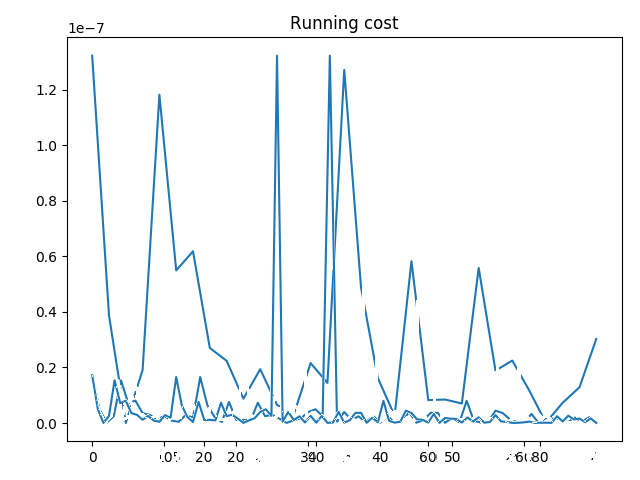

In [42]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [43]:
## optimize

num_iterations = 1000
num_samples_per_iteration = 10000
step_rate = 1e-1
slack_var = .0

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    samples = torch.randn(2,num_samples_per_iteration).type(dtype)
    many_x_i = Variable(samples, requires_grad=True)
    Vdot = compute_Vdot_vectorized(many_x_i)
    cost = Vdot.clamp(min=-slack_var).sum()
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    #P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    #P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    #P.data = P.data/(P.data.pow(2).sum())
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    #P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 10 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K
    
    if cost_iteration == num_iterations - 1:
        print "didn't converge"

first P is Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]

first K is Variable containing:
 2.8229
 5.6439
-5.6454
[torch.FloatTensor of size 3]

0.0067720413208 is time for one step of grad descent

1.32292782951e-07
P is Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]

K is Variable containing:
 2.8229
 5.6439
-5.6454
[torch.FloatTensor of size 3]

0.00542402267456 is time for one step of grad descent

3.87762497667e-08
P is Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]

K is Variable containing:
 2.8229
 5.6439
-5.6454
[torch.FloatTensor of size 3]

0.00541806221008 is time for one step of grad descent

3.62856411584e-11
P is Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]

K is Variable containing:
 2.8229
 5.6439
-5.6454
[torch.FloatTensor of size 3]

0.00542593002319 is time for one step of grad descent

1.90302564818e-08
P is Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]

K is Var

0.00622081756592 is time for one step of grad descent

5.95620797128e-09
P is Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]

K is Variable containing:
 2.8227
 5.6442
-5.6452
[torch.FloatTensor of size 3]

0.00596189498901 is time for one step of grad descent

8.14253553472e-10
P is Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]

K is Variable containing:
 2.8227
 5.6442
-5.6452
[torch.FloatTensor of size 3]

0.0045280456543 is time for one step of grad descent

3.12852943551e-09
P is Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]

K is Variable containing:
 2.8227
 5.6442
-5.6452
[torch.FloatTensor of size 3]

0.00449895858765 is time for one step of grad descent

3.39723804643e-08
P is Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]

K is Variable containing:
 2.8227
 5.6442
-5.6452
[torch.FloatTensor of size 3]

0.00432395935059 is time for one step of grad descent

2.74589986304e-08
P is Variable contai

In [44]:
print K
print P

Variable containing:
 2.8227
 5.6443
-5.6451
[torch.FloatTensor of size 3]

Variable containing:
 0.9718
 0.8902
[torch.FloatTensor of size 2]



In [45]:
# THIS IS THE ANSWER
#K = Variable(torch.FloatTensor([0.5*m*l**2, m*g*l, -m*g*l]).type(dtype), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2).type(dtype), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 1e-2:
        print "false, counterexample found: ", x_i
        print i
        print Vdot.data[0]
        break

In [21]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term